# Configuration.
Enter the paths to the file containting the validation data and the path to the builderConnectivityRecipeAllPathways.xml used.

The validation data is obtained using the "validate_bouton_density.py" or "validate_syns_con.py" scripts.
Please also specify the modality of the validation data: "syns_con" or "bouton_density"

In [1]:
fn = "/home/reimann/Documents/data/SSCX/validation/Bio_0/post-adjustment1/bouton_density_central_column.csv"
fn_recipe = "/home/reimann/Documents/data/SSCX/validation/Bio_0/post-adjustment1/builderConnectivityRecipeAllPathways.xml"
#data_modality = "syns_con"
data_modality = "bouton_density"


Here, we configure some things that differ depending on the modality of the data.

In [2]:
if data_modality == "syns_con":
    lo_key = "from"
    recipe_set_key = "mean_syns_connection"
    min_val = 1.0
    max_val = 1E20
elif data_modality == "bouton_density":
    lo_key = "mtype"
    recipe_set_key = "bouton_reduction_factor"
    min_val = 0.0
    max_val = 1.0

# Read data
We import required packages and read in the data.
We also define a convenience function that determines if an m-type is excitatory or inhibitory. 
This serves plotting purposes, so we can plot data for exc. and inh. types separately. This function was written
for SSCX or mouse neocortex circuits, for other models you might have to update!

In [3]:
import pandas
import numpy
from matplotlib import pyplot as plt

data = pandas.read_csv(fn)
data = data.loc[~numpy.isnan(data['Error'])]
display(data)

def mtype_is_excitatory(str_m):
    if "PC" in str_m:
        return True
    if "SSC" in str_m:
        return True
    return False

,mtype,Mean (data),Std (data),Mean (ref.),Std (ref.),Error
0,*,0.1920,0.0586,0.1914,0.06379,0.980472
1,L1_DAC,0.1710,0.0760,0.1824,0.02527,-22.514071
2,L1_HAC,0.1930,0.1090,0.1997,0.04176,-8.888299
3,L1_LAC,0.2220,0.1050,0.2200,0.01001,3.477958
4,L1_NGC-DA,0.1800,0.0998,0.2017,0.04812,-29.340184
5,L1_NGC-SA,0.1780,0.0937,0.1850,0.04766,-9.903792
6,L1_SAC,0.1680,0.0858,0.1837,0.05502,-22.297969
7,L23_BP,0.2010,0.0412,0.1861,0.00000,72.330097
8,L23_BTC,0.2050,0.0511,0.2020,0.03921,6.643783
9,L23_CHC,0.0668,0.0174,0.2318,0.04466,-531.743474


# Plot results: Comparison to reference

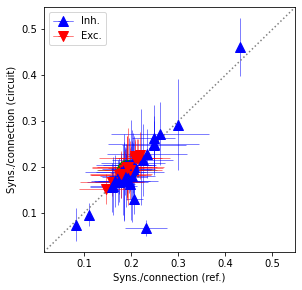

In [4]:
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
lbl_e = "Exc."; lbl_i = "Inh."

for i, row in data.iterrows():
    if i == 0:
        col = "green"
        marker = "o"
        ms = 20
        label=None
    elif mtype_is_excitatory(row[lo_key]):
        col = "red"
        marker = "v"
        ms = 10
        label=lbl_e
        lbl_e = None
    else:
        col = "blue"
        marker = "^"
        ms = 10
        label=lbl_i
        lbl_i = None
    ax.errorbar(row["Mean (ref.)"], row["Mean (data)"], xerr=row["Std (ref.)"], yerr=row["Std (data)"],
               color=col, marker=marker, ms=ms, lw=0.5, label=label)

lims = numpy.vstack([ax.get_xlim(), ax.get_ylim()])
lims = [numpy.min(lims[:, 0]), numpy.max(lims[:, 1])]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(lims, lims, color='grey', ls=":")
ax.set_xlabel("Syns./connection (ref.)")
ax.set_ylabel("Syns./connection (circuit)")
plt.legend()

# Plot results: Relative error

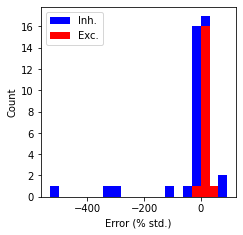

In [5]:
error_bins = numpy.linspace(numpy.nanmin(data["Error"]),
                            numpy.nanmax(data["Error"]), 21)
bin_centers = 0.5 * (error_bins[:-1] + error_bins[1:])
w = error_bins[1] - error_bins[0]
lbl_e = "Exc."; lbl_i = "Inh."

is_exc = data[lo_key].apply(mtype_is_excitatory)
H_exc = numpy.histogram(data["Error"][is_exc], bins=error_bins)[0]
H_inh = numpy.histogram(data["Error"][~is_exc], bins=error_bins)[0]

fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.gca()

for x, y1, y2 in zip(bin_centers, H_exc, H_inh):
    if y1 > y2:
        ax.bar(x, y1, color='red', width=w, label=lbl_e)
        ax.bar(x, y2, color='blue', width=w, label=lbl_i)
    else:
        ax.bar(x, y2, color='blue', width=w, label=lbl_i)
        ax.bar(x, y1, color='red', width=w, label=lbl_e)
    lbl_e = None; lbl_i = None

ax.set_xlabel("Error (% std.)")
ax.set_ylabel("Count")
plt.legend()

# Optional: Update connectivity recipe
This is an optional and rather hacky idea:
We update the parameters given in the builderConnectivityRecipeAllPathways.xml file with the aim to better fit the biological data.

We begin by building a linear fit between circuit data and the biological reference. Then we use the slope of the fit as a scaling factor of the corresponding parameter in the recipe.

In [6]:
import statsmodels.formula.api as smf
from patsy import ModelDesc

sm_model = ModelDesc.from_formula("ref ~ data - 1")
sm_result = smf.ols(sm_model, {"ref": data["Mean (ref.)"], "data": data["Mean (data)"]}).fit()

print(sm_result.params)

data    0.803429
dtype: float64


In [7]:
import os
from lxml import etree

def update_connectivity_recipe(fn_in, fn_out, set_key, set_fac):
    tree = etree.parse(fn_in)
    root = tree.getroot()
    for c in root.getchildren():
        if c.get(set_key) is not None:
            v_out = set_fac * float(c.get(set_key))
            v_out = numpy.maximum(min_val,
                                 numpy.minimum(max_val, v_out))
            c.set(set_key, str(v_out))
    
    if os.path.exists(fn_out) and False:
        raise ValueError("{0} already exists. Not overwriting!".format(fn_out))
    with open(fn_out, "wb") as fid:
        fid.write(etree.tostring(tree, encoding="UTF-8", xml_declaration=True))
    return tree


In [8]:
fn_recipe_out = os.path.splitext(fn_recipe)[0] + data_modality + "_fix.xml"
update_connectivity_recipe(fn_recipe, fn_recipe_out, recipe_set_key, sm_result.params["data"])